In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import lsqlin
from scipy import stats
import copy 

In [2]:
vix_df = pd.read_excel( 'VIXfutures_20080414_20201231.xlsx' )

vix_df = vix_df.sort_values( by = ['Date'], ascending = True )

x_df = vix_df[ [ 'Date', 'VIX', 'w', \
                       'CMF30', 'CMF60', 'CMF90', 'CMF120', 'CMF150', \
                       'roll30', 'roll60', 'roll90', 'roll120', 'roll150', \
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9' ] ]

# for eache row, if it contains a non-number element in a column, then drop the entire row
x_df = x_df.dropna()

# for eache row, if it contains a 0 element in a column, then drop the entire row
#x_df = x_df.loc[ ( x_df != 0 ).all( axis = 1 ) ]

# reset the index
x_df= x_df.reset_index( drop = True )

dates = x_df[ 'Date' ]

In [3]:
vix = x_df.VIX 
T = len(vix)

v_1 = x_df.CMF30 
v_2 = x_df.CMF60 
v_3 = x_df.CMF90 
v_4 = x_df.CMF120 
v_5 = x_df.CMF150 

d_theta_log_v_1 = x_df.roll30 
d_theta_log_v_2 = x_df.roll60 
d_theta_log_v_3 = x_df.roll90 
d_theta_log_v_4 = x_df.roll120 
d_theta_log_v_5 = x_df.roll150 

In [4]:
vix_etn_number = 10
x_row = vix_etn_number + 1  #  plus 1 here is for the VIX
x_column = len( v_1 );
X = np.ones( ( x_row, x_column ) )

X[ 0, : ] =  np.log( vix )

X[ 1, : ] =  np.log( v_1 )
X[ 2, : ] =  np.log( v_2 )
X[ 3, : ] =  np.log( v_3 )
X[ 4, : ] =  np.log( v_4 )
X[ 5, : ] =  np.log( v_5 )

X[ 6, : ] = d_theta_log_v_1
X[ 7, : ] = d_theta_log_v_2
X[ 8, : ] = d_theta_log_v_3
X[ 9, : ] = d_theta_log_v_4
X[ 10, : ] = d_theta_log_v_5



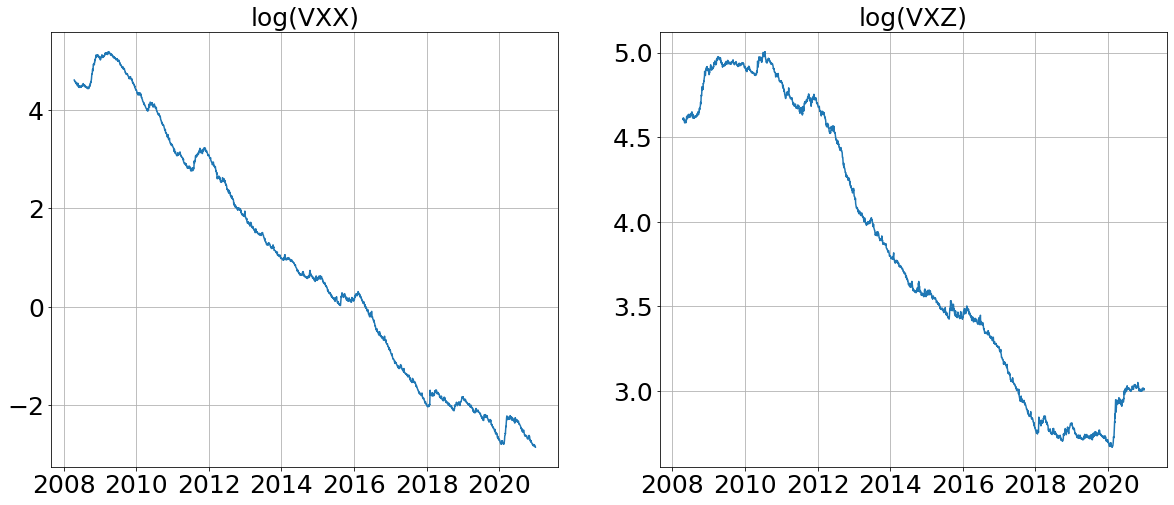

In [19]:
dt = 1/252;
r = .03
vxx = np.zeros(T)
vxz = np.zeros(T)
vxx[0]=100
vxz[0]=100
for t in range(T-1):
    vxx[t+1] = vxx[t]*(1+r*dt + X[ 6, t+1 ]*dt  + (X[ 1, t+1 ]-X[ 1, t ])/X[ 1, t ]  )
    vxz[t+1] = vxz[t]*(1+r*dt + X[ 10, t+1 ]*dt  + (X[ 5, t+1 ]-X[ 5, t ])/X[ 5, t ]  )

fig, axs = plt.subplots( 1, 2, figsize = ( 20, 8 ) )
#fig.suptitle( 'Log of VXX and VXZ', fontsize = 25 )
axs[ 0 ].plot(dates,np.log(vxx));
axs[ 0].tick_params( axis = 'both', which = 'major', labelsize = 25 )
axs[ 0].set_title('log(VXX)', fontsize = 25 )
axs[ 0].grid( which = 'major' )
axs[ 0 ].grid( which = 'minor', linestyle = ':' )

axs[ 1 ].plot(dates,np.log(vxz));
axs[ 1].tick_params( axis = 'both', which = 'major', labelsize = 25 )
axs[ 1].set_title('log(VXZ)', fontsize = 25 )
axs[ 1].grid( which = 'major' )
axs[ 1 ].grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture17/logVXXandlogVXZ.eps', format = 'eps', bbox_inches = 'tight' )




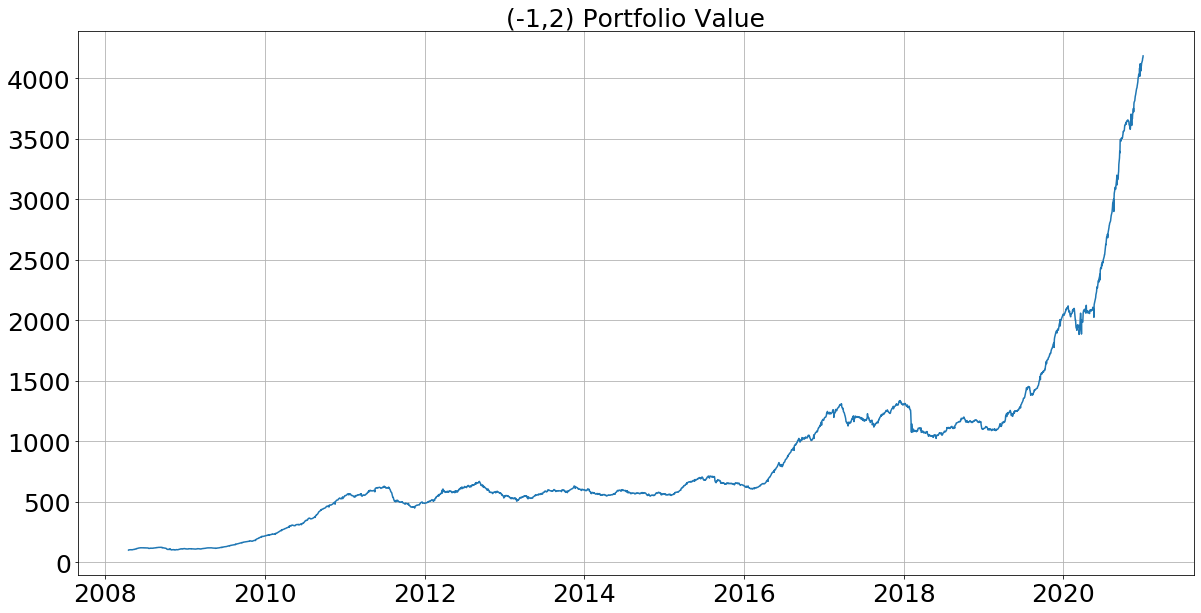

In [25]:
p_trade = np.zeros(T)
collateral = np.zeros(T)
cash = np.zeros(T)
n1 = np.zeros(T)
n2 = np.zeros(T)

p_trade[0] = 100

w1 = -1
w2 = 2
w0 = 1-w1-w2

n1[0] = w1*p_trade[0]/vxx[0]
n2[0] = w2*p_trade[0]/vxz[0]

alpha = 2.5   ### percentage of short value required in collateral
collateral[0] = -alpha*n1[0]*vxx[0] - n2[0]*vxz[0]
cash[0] = p_trade[0] - n1[0]*vxx[0]- n2[0]*vxz[0]

eps = .001  #### 10bps transaction costs

for t in range(T-1):
    p_trade[t+1] = p_trade[t]*(1 +w0*r*dt) + n1[t]*(vxx[t+1]-vxx[t]) + n2[t]*(vxz[t+1]-vxz[t])
    
    n1[t+1] = w1*p_trade[t+1]/vxx[t+1]
    n2[t+1] = w2*p_trade[t+1]/vxz[t+1]
    
    p_trade[t+1] = p_trade[t+1]  - eps * vxx[t+1]*np.abs(n1[t+1]-n1[t] ) \
                        - eps * vxz[t+1]*np.abs(n2[t+1]-n2[t] )
    
    collateral[t+1] = -alpha*n1[t+1]*vxx[t+1]  - n2[t+1]*vxz[t+1]
    cash[t+1] = p_trade[t+1] - n1[t+1]*vxx[t+1] -n2[t+1]*vxz[t+1]

np.log(p_trade[-1]/p_trade[0])/(T*dt)


plt.figure( figsize = ( 20, 10 ) )
plt.plot(dates,p_trade);
plt.title('(-1,2) Portfolio Value', fontsize = 25 )
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture17/shortVXX_2timesLongVXZportfolio.eps', format = 'eps', bbox_inches = 'tight' );


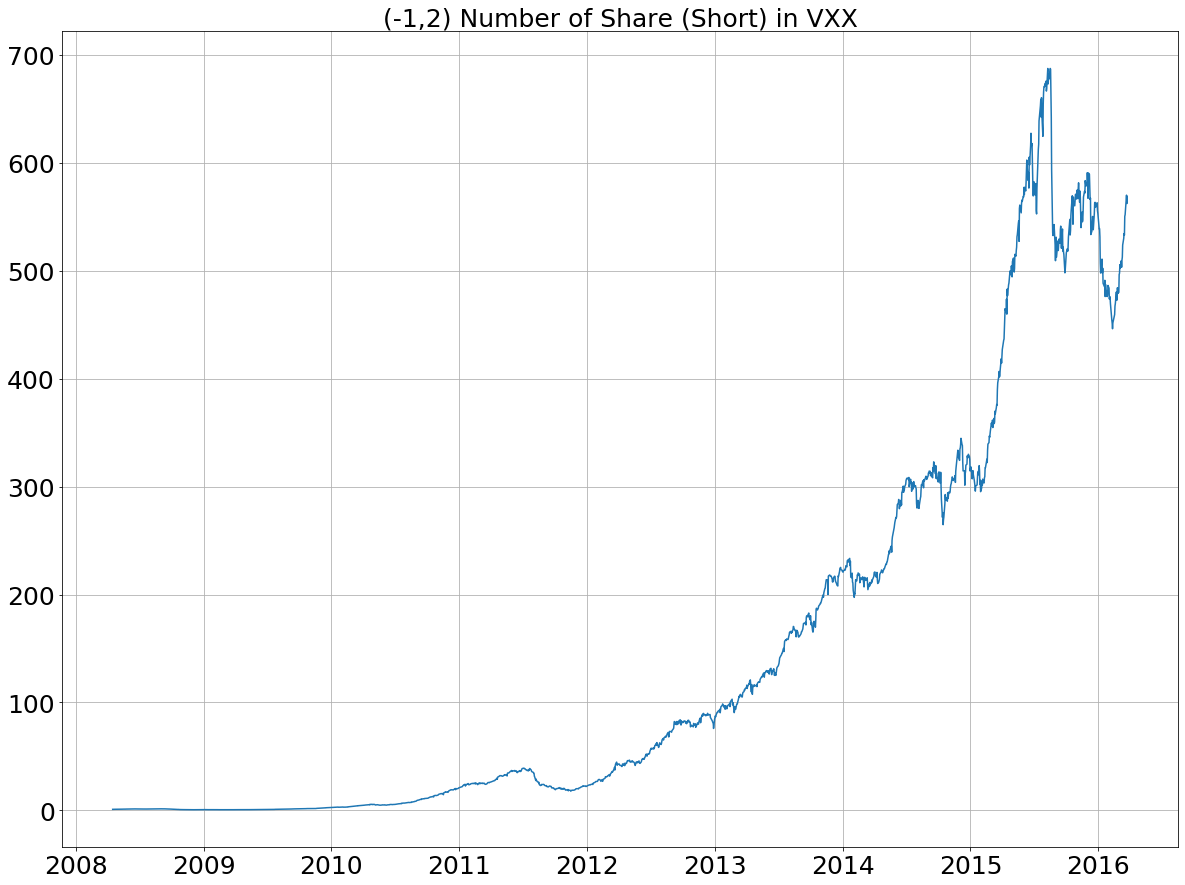

In [21]:
plt.figure( figsize = ( 20, 15 ) )
plt.plot(dates[0:2000],-n1[0:2000])
plt.title('(-1,2) Number of Share (Short) in VXX', fontsize = 25 )
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture17/sharesShortVXX.eps', format = 'eps', bbox_inches = 'tight' );



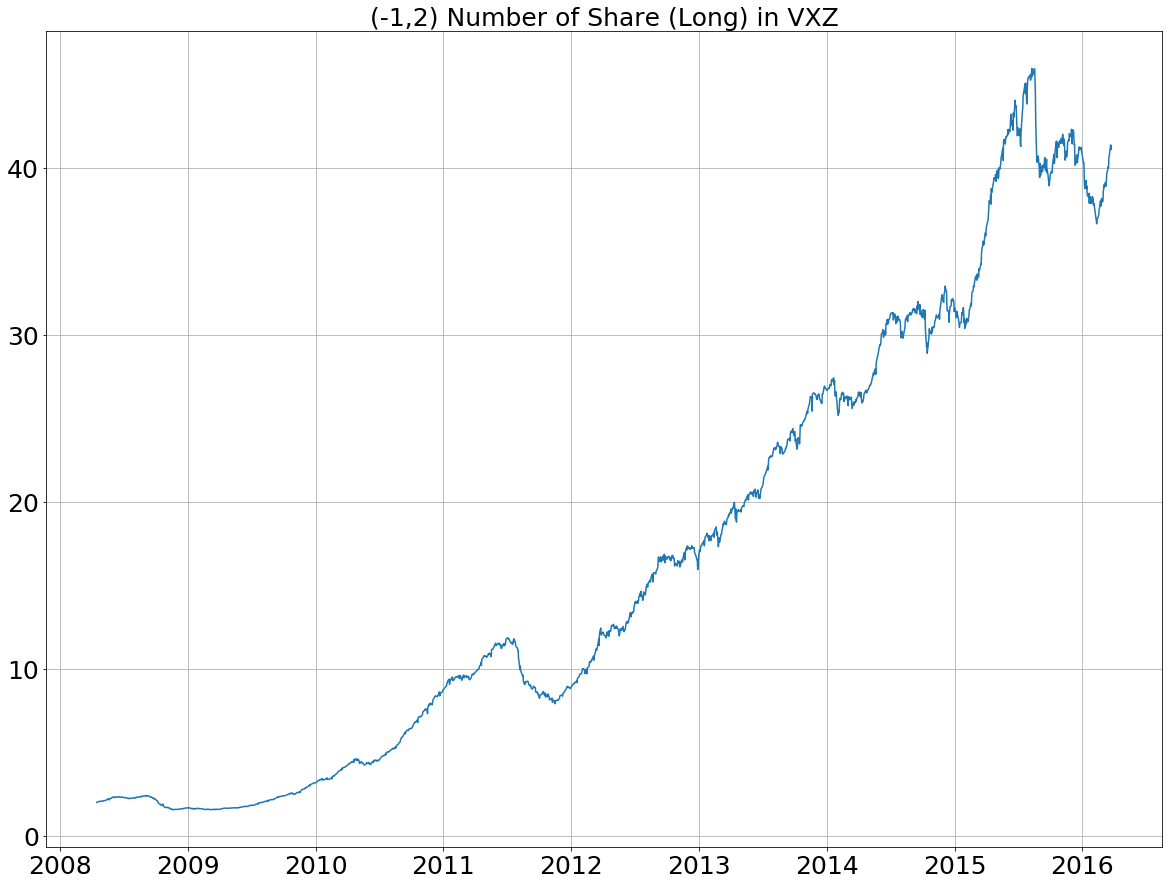

In [22]:
plt.figure( figsize = ( 20, 15 ) )
plt.plot(dates[0:2000],n2[0:2000])
plt.title('(-1,2) Number of Share (Long) in VXZ', fontsize = 25 )
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture17/sharesLongVXZ.eps', format = 'eps', bbox_inches = 'tight' );

In [9]:
np.log(p_trade[2000]/p_trade[0])/(2000*dt)

0.23578508630695377

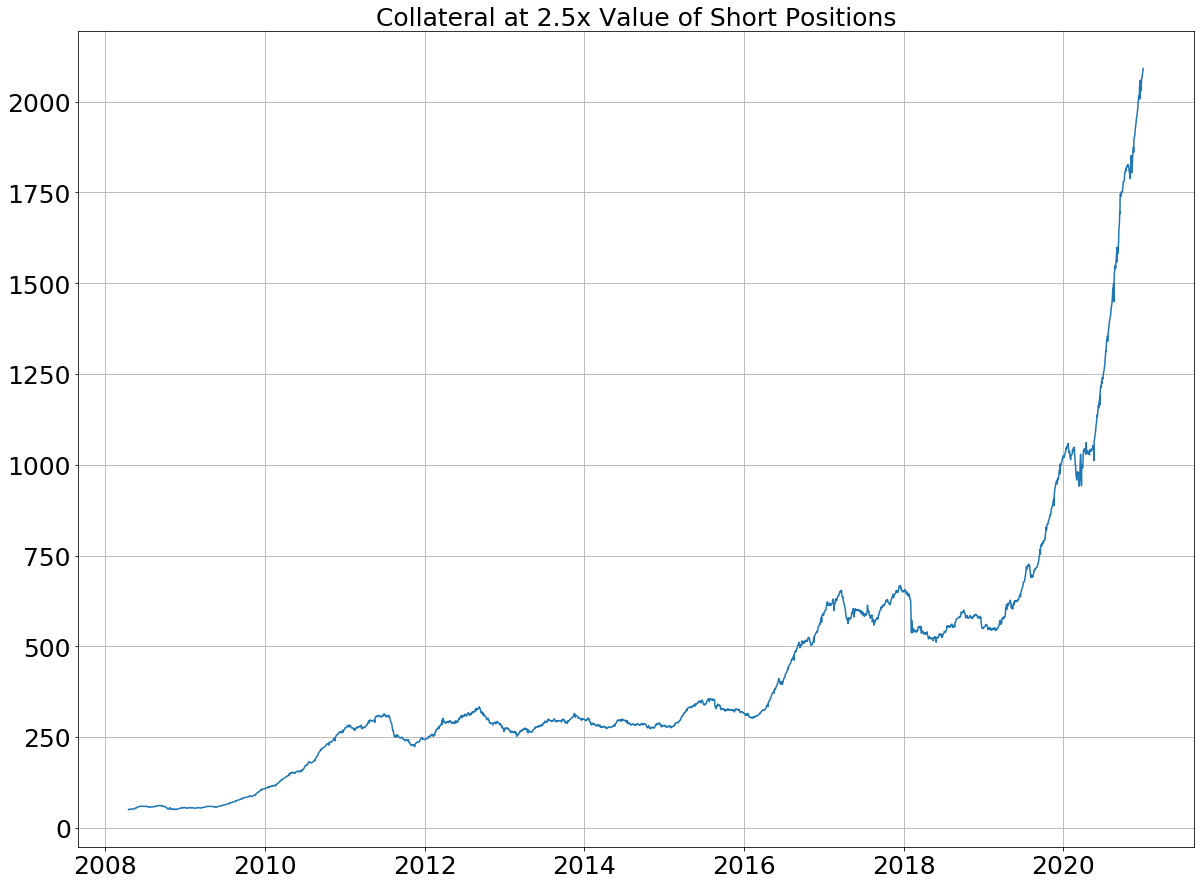

In [23]:
plt.figure( figsize = ( 20, 15 ) )
plt.plot(dates,collateral)
plt.title('Collateral at '+str(alpha)+'x Value of Short Positions',fontsize=25);
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture17/collateral.eps', format = 'eps', bbox_inches = 'tight' );